# Calendar Features

This notebook aims to explore the impact of calendar features on sales. Questions this notebook aims to answer include: 
1. How does calendar features impact sales for items in different departments?
2. Are the created correlation features a reliable indicator of calendar effects on the specific items?

An important piece of information is that 2011 is not a complete date. This is what was driving the odd rolling averages. I need to fix this everywhere. 
Like wise I have learned that the last month (2016-03) is incomplete. I will filter it now. 

In [1]:
# Import required libraries
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.metrics import dtw
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(project_root)

# Now you can import from core if needed
from src.core.clients.bigquery import BigQueryClient

bq_client = BigQueryClient()

sales_query = """
    SELECT 
        tgt.ctx_date_month,
        tgt.ctx_cat_id, 
        tgt.ctx_dept_id, 
        tgt.ctx_item_id,
        tgt.tgt_monthly_sales,
        tgt.tgt_monthly_sales_sum_3_next_months
    FROM `porygon-pipelines.walmart_targets_and_filters.target_store_item_monthly` tgt
    LEFT JOIN `porygon-pipelines.walmart_targets_and_filters.stockout_filter` stckt
        ON tgt.ctx_item_id = stckt.ctx_item_id
        AND tgt.ctx_store_id = stckt.ctx_store_id
        AND tgt.ctx_date_month = stckt.ctx_date_month
    WHERE 
        tgt.ctx_store_id = 'CA_1'
        AND stckt.is_stockout_tgt = 0
"""

calendar_features_query = """
    SELECT 
        *
    FROM `porygon-pipelines.walmart_featurestore.calendar_features`
"""
# Extract data
item_sales = bq_client.load_from_query(sales_query)
calendar_features = bq_client.load_from_query(calendar_features_query)

item_sales = item_sales[item_sales["tgt_monthly_sales"]>0]
item_sales = item_sales[
    (item_sales["ctx_date_month"]>=pd.to_datetime("2011-02-01"))
    & (item_sales["ctx_date_month"]<=pd.to_datetime("2016-02-01"))
     ]

# Merge dataframes on 'ctx_date_month'
df_merged = item_sales.merge(
    calendar_features,
    on="ctx_date_month",
)



/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/tslearn/bases/bases.py:16: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
INFO:src.core.clients.bigquery:BigQuery client initialized for project: porygon-pipelines
/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
INFO:src.core.clients.bigquery:Loaded 121003 rows from custom query.
INFO:src.core.clients.bigquery:Loaded 66 rows from custom query.
/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
INFO:src.core.clients.bigquery:Loaded 195136 rows f

# Create Diffed Target

In [2]:
df_merged["ctx_date_month"] = pd.to_datetime(df_merged["ctx_date_month"])
df_merged["tgt_monthly_sales_sum_3_next_months_diff"] = df_merged.sort_values("ctx_date_month").groupby("ctx_item_id")["tgt_monthly_sales_sum_3_next_months"].diff()



# Utils functions



In [ ]:
def plot_effect_on_tgt_per_dept_list(dept_list, feature_name, target_name="tgt_monthly_sales_sum_3_next_months_diff"):
    import numpy as np
    departments = np.array(dept_list)
    quantiles = [0.25, 0.5, 0.75]
    nrows = len(departments)//2 + len(departments)%2
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(12, 5*nrows))  # Increased vertical space
    axes = axes.flatten()

    for i, dept in enumerate(departments):
        ax = axes[i]
        df_dept = df_merged[df_merged['ctx_dept_id'] == dept]
        q_df = df_dept.groupby(feature_name)[[target_name]].quantile(quantiles).reset_index().pivot(
            index=feature_name, columns='level_1', values=target_name)
        q_df.plot(ax=ax, marker='o')
        ax.set_title(f"{dept} - Sales Quantiles by {feature_name}")
        ax.set_xlabel(feature_name)
        ax.set_ylabel('Sales')
        ax.legend([f"Q{int(q*100)}" for q in quantiles])
        ax.grid(True)

    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(h_pad=3.0)  # Add more vertical padding
    plt.show()

# Create regression iteration function
def iterate_regression_over_features_and_departments(event_cols, target_name = "tgt_monthly_sales_sum_3_next_months_diff"):
    results = {}
    significant_results = []
    for event_col in event_cols:
        df_merged[event_col] = df_merged[event_col].fillna(0)
        df_merged[event_col] = df_merged[event_col].astype(float)
        for dept in df_merged['ctx_dept_id'].unique():
            dept_df = df_merged[df_merged['ctx_dept_id'] == dept].copy()
            X = dept_df[event_col]
            X = sm.add_constant(X)
            y = dept_df[target_name]
            model = sm.OLS(y, X, missing='drop').fit()
            results[dept+"-"+event_col] = model
            coef = model.params.get(event_col, None)
            pval = model.pvalues.get(event_col, None)
            if coef is not None and pval is not None and pval < 0.06:
                significant_results.append({'department': dept, 'coef': coef, 'p_value': pval, 'feature': event_col})
    df_significant = pd.DataFrame(significant_results)
    df_significant["abs_coef"] = df_significant["coef"].abs()
    return results, df_significant


def plot_calendar_against_month_sin(feature_name):
    fig, ax1 = plt.subplots(figsize=(12,5))
    sns.lineplot(data=df_merged, x='ctx_date_month', y=feature_name, marker='o', ax=ax1, color='tab:blue', label=feature_name)
    ax1.set_ylabel(feature_name, color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    sns.lineplot(data=df_merged, x='ctx_date_month', y='fea_month_sin', marker='o', ax=ax2, color='tab:orange', label='month_sin')
    ax2.set_ylabel('fea_month_sin', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    ax1.set_title(f'{feature_name} and fea_month_sin over Time')
    ax1.set_xlabel('Month')
    fig.tight_layout()
    plt.show()

def plot_tgt_impact_per_feature(dept_id, feature_name):
    fig, ax1 = plt.subplots(figsize=(12,5))
    sns.lineplot(data=df_merged[
        df_merged["ctx_dept_id"]==dept_id
    ], x='ctx_date_month', y='tgt_monthly_sales_sum_3_next_months_diff', marker='o', ax=ax1, color='tab:blue', label="tgt_monthly_sales_sum_3_next_months_diff")
    ax1.set_ylabel('tgt_monthly_sales_sum_3_next_months_diff', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax2 = ax1.twinx()
    sns.lineplot(data=df_merged[
        df_merged["ctx_dept_id"]==dept_id
    ], x='ctx_date_month', y=feature_name, marker='o', ax=ax2, color='tab:orange', label=feature_name)
    ax2.set_ylabel(feature_name, color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax1.set_title(f'tgt_monthly_sales_sum_3_next_months_diff and {feature_name} over Time')
    ax1.set_xlabel('Month')
    fig.tight_layout()
    plt.show()


# Regression per dept

In [17]:
EVENT_COLS = [ 'fea_is_weekend_3m', 'fea_is_event_1_3m', 'fea_is_event_2_3m',
       'fea_is_sporting_event_3m', 'fea_is_cultural_event_3m',
       'fea_is_national_event_3m', "fea_month_sin" ]

results, df_significant = iterate_regression_over_features_and_departments(event_cols=EVENT_COLS, target_name = "tgt_monthly_sales_sum_3_next_months_diff")



In [18]:
display(df_significant.sort_values(by='feature', ascending = False))

department       coef       p_value                   feature   abs_coef
39    HOBBIES_2  -2.580742  3.589841e-03             fea_month_sin   2.580742
38  HOUSEHOLD_2   1.942272  2.006844e-36             fea_month_sin   1.942272
37  HOUSEHOLD_1   4.574437  1.390043e-55             fea_month_sin   4.574437
36    HOBBIES_1   2.252751  1.005082e-06             fea_month_sin   2.252751
35      FOODS_3  15.324467  3.187882e-54             fea_month_sin  15.324467
34      FOODS_2  -2.094181  1.623994e-04             fea_month_sin   2.094181
33      FOODS_1   3.635781  2.696520e-04             fea_month_sin   3.635781
1       FOODS_3   6.494805  3.706279e-06         fea_is_weekend_3m   6.494805
0       FOODS_2   4.287597  4.932420e-08         fea_is_weekend_3m   4.287597
2     HOBBIES_1   4.258805  6.541405e-11         fea_is_weekend_3m   4.258805
4   HOUSEHOLD_2   0.510688  2.105118e-02         fea_is_weekend_3m   0.510688
3   HOUSEHOLD_1   2.060653  4.110171e-07         fea_is_weekend_3m   2.060653
20  HOUSEHOLD_2   1.122611  8.453350e-18  fea_is_sporting_event_3m   1.122611
17      FOODS_1   4.656742  6.328830e-08  fea_is_sporting_event_3m   4.656742
21    HOBBIES_2  -4.360093  1.770895e-08  fea_is_sporting_event_3m   4.360093
18      FOODS_3   8.162918  1.560810e-21  fea_is_sporting_event_3m   8.162918
19  HOUSEHOLD_1   3.123259  3.293960e-35  fea_is_sporting_event_3m   3.123259
30    HOBBIES_1  -1.464097  4.008740e-10  fea_is_national_event_3m   1.464097
32  HOUSEHOLD_2  -0.782853  3.783718e-23  fea_is_national_event_3m   0.782853
31  HOUSEHOLD_1  -1.795296  3.157647e-34  fea_is_national_event_3m   1.795296
28      FOODS_2   0.797430  4.736131e-03  fea_is_national_event_3m   0.797430
29      FOODS_3  -6.435137  5.533407e-38  fea_is_national_event_3m   6.435137
16  HOUSEHOLD_2   1.823922  8.611539e-13         fea_is_event_2_3m   1.823922
15  HOUSEHOLD_1   3.123787  1.316456e-10         fea_is_event_2_3m   3.123787
14    HOBBIES_1   3.754620  8.222530e-07         fea_is_event_2_3m   3.754620
13      FOODS_3  13.731912  5.983156e-17         fea_is_event_2_3m  13.731912
12      FOODS_1   7.224193  2.880694e-05         fea_is_event_2_3m   7.224193
5       FOODS_1   2.100357  2.132830e-10         fea_is_event_1_3m   2.100357
6       FOODS_2  -0.958463  1.378662e-07         fea_is_event_1_3m   0.958463
7       FOODS_3   0.902323  6.218308e-03         fea_is_event_1_3m   0.902323
9   HOUSEHOLD_1   0.323732  8.054048e-04         fea_is_event_1_3m   0.323732
10  HOUSEHOLD_2   0.345215  1.407034e-11         fea_is_event_1_3m   0.345215
8     HOBBIES_1  -0.643995  2.897531e-05         fea_is_event_1_3m   0.643995
11    HOBBIES_2  -1.501539  2.669317e-07         fea_is_event_1_3m   1.501539
27  HOUSEHOLD_2   0.953509  9.433141e-29  fea_is_cultural_event_3m   0.953509
26  HOUSEHOLD_1   1.212581  1.286223e-13  fea_is_cultural_event_3m   1.212581
25    HOBBIES_1   0.692829  7.297612e-03  fea_is_cultural_event_3m   0.692829
23      FOODS_2  -1.853536  2.942558e-09  fea_is_cultural_event_3m   1.853536
22      FOODS_1   2.436587  1.156092e-05  fea_is_cultural_event_3m   2.436587
24      FOODS_3   5.693547  4.414604e-25  fea_is_cultural_event_3m   5.693547

## Feature Is National Event

I decided to start with this one because it is affecting the largest number of departments (5).

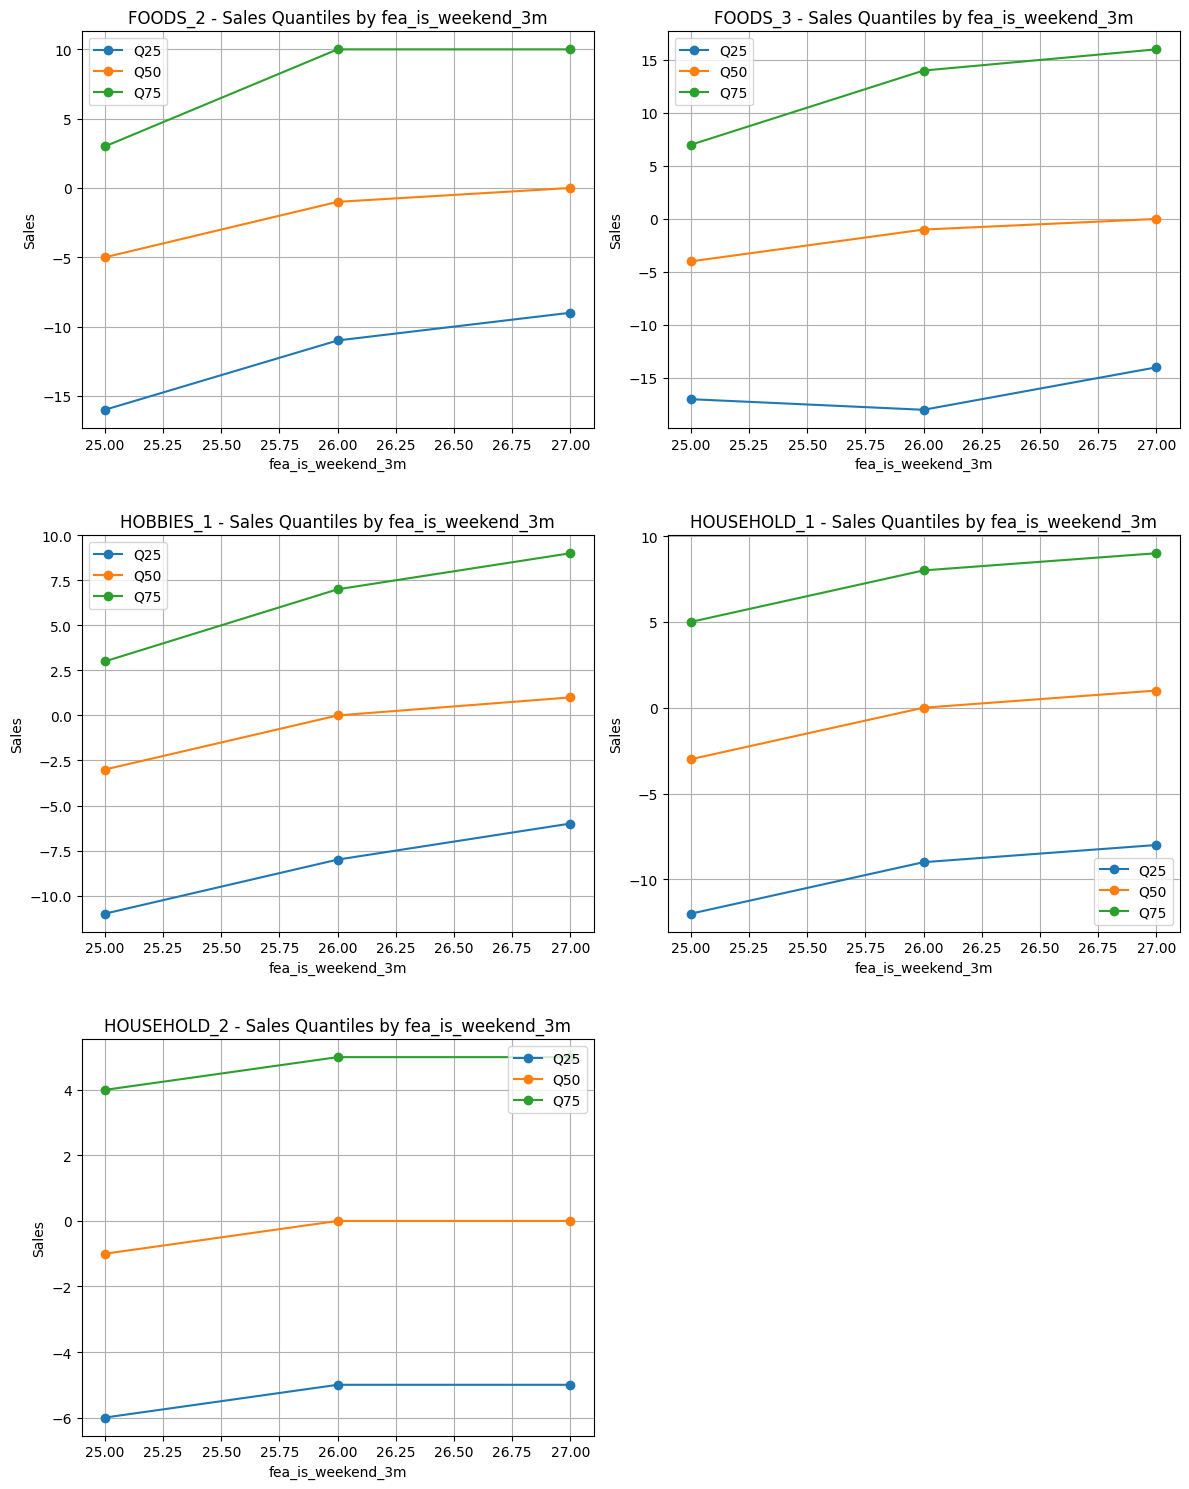

In [40]:
unique_depts = list(df_significant[df_significant["feature"]=="fea_is_weekend_3m"]["department"].unique())
plot_effect_on_tgt_per_dept_list(
    dept_list=unique_depts, 
    feature_name = "fea_is_weekend_3m"
)


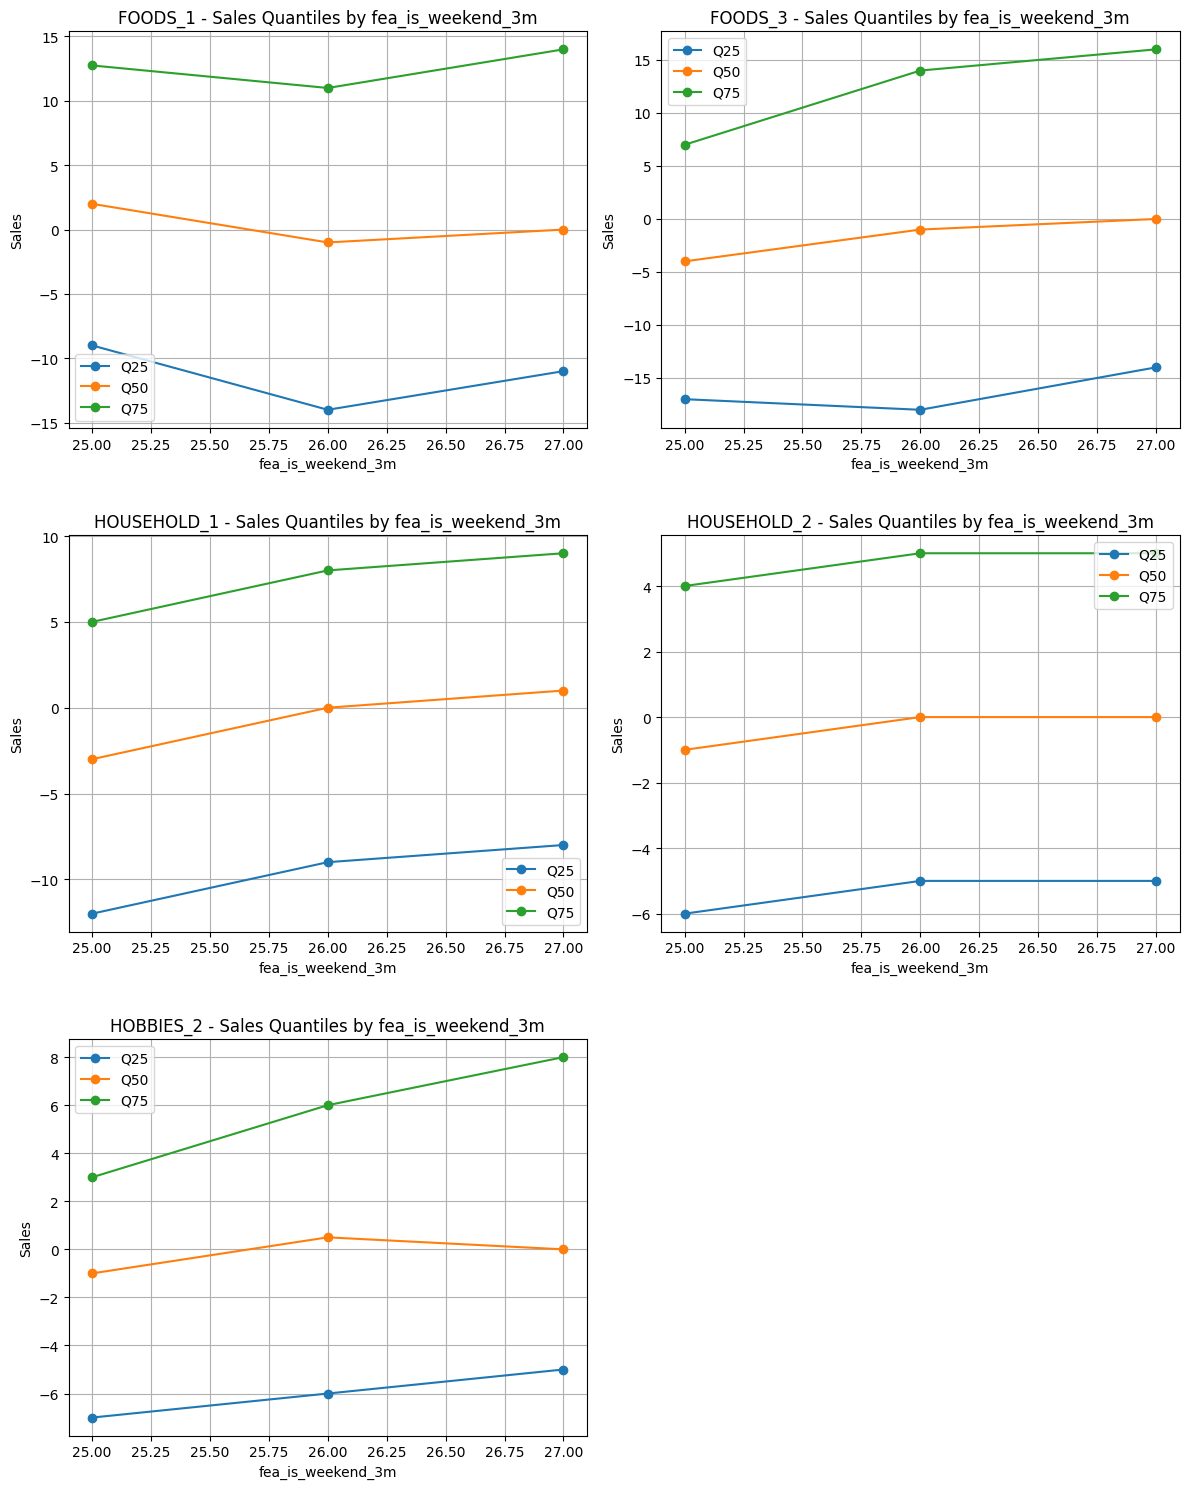

In [41]:
unique_depts = list(df_significant[df_significant["feature"]=="fea_is_sporting_event_3m"]["department"].unique())
plot_effect_on_tgt_per_dept_list(
    dept_list=unique_depts, 
    feature_name = "fea_is_weekend_3m"
)


# Plot Diff Against Features

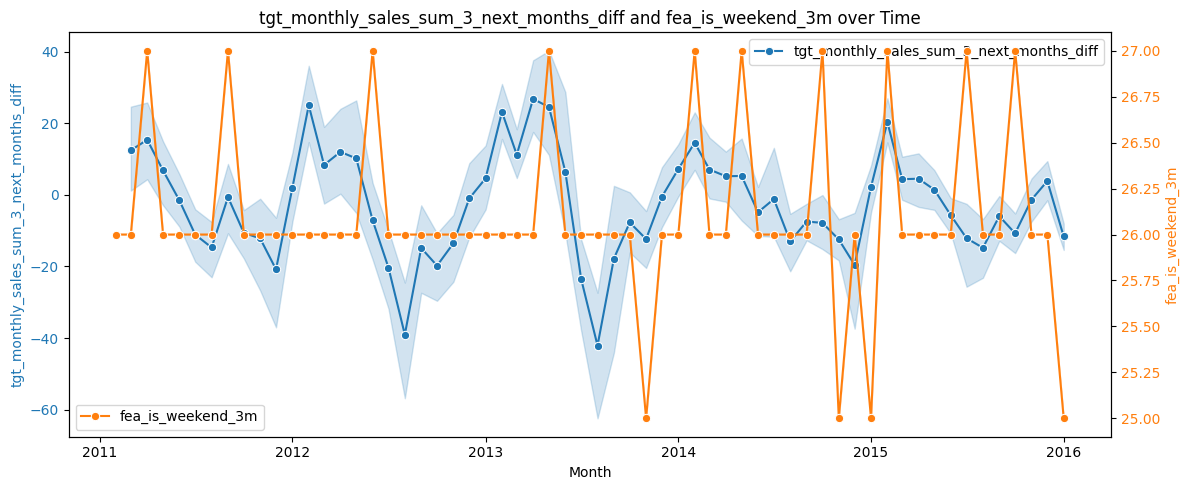

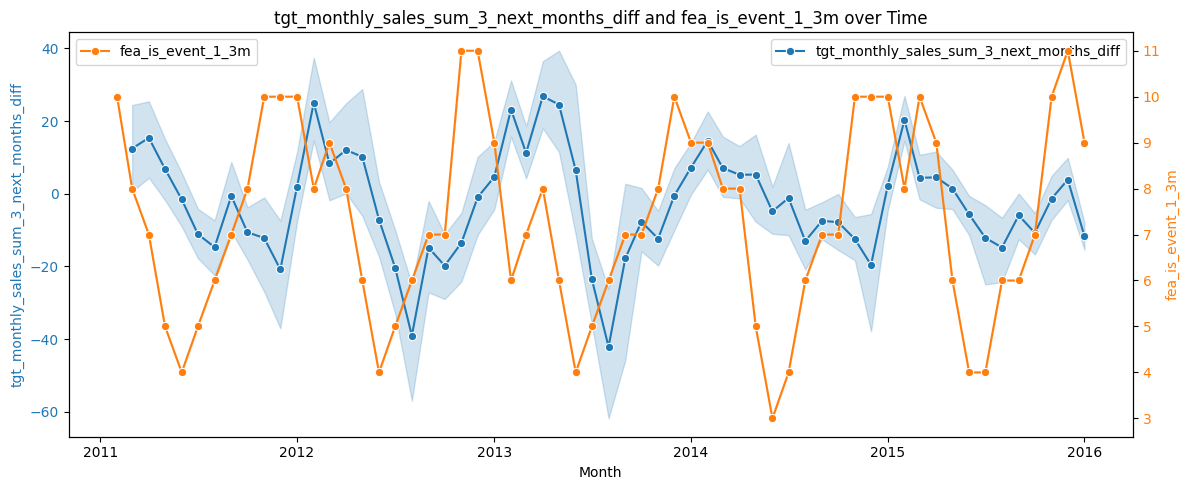

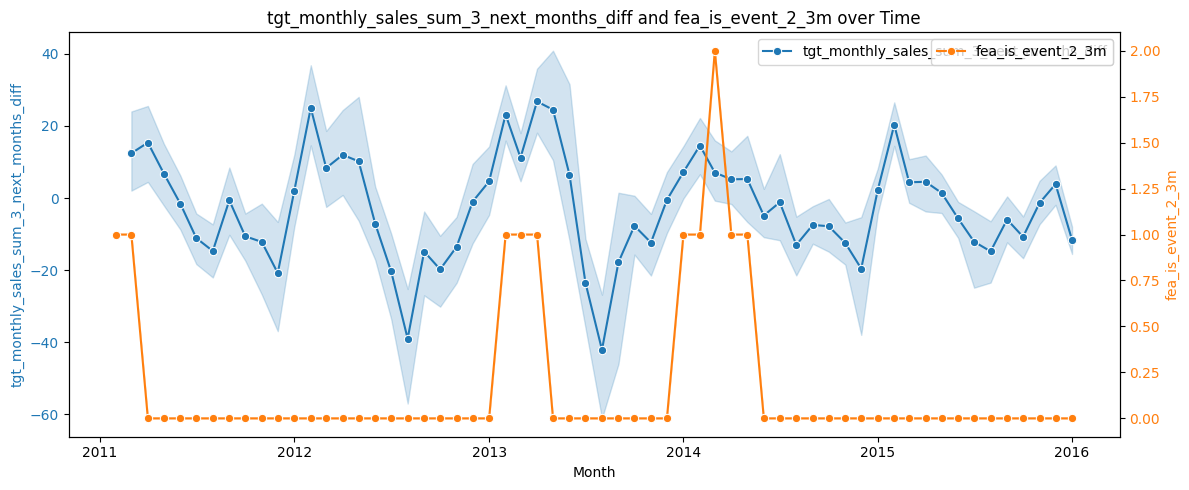

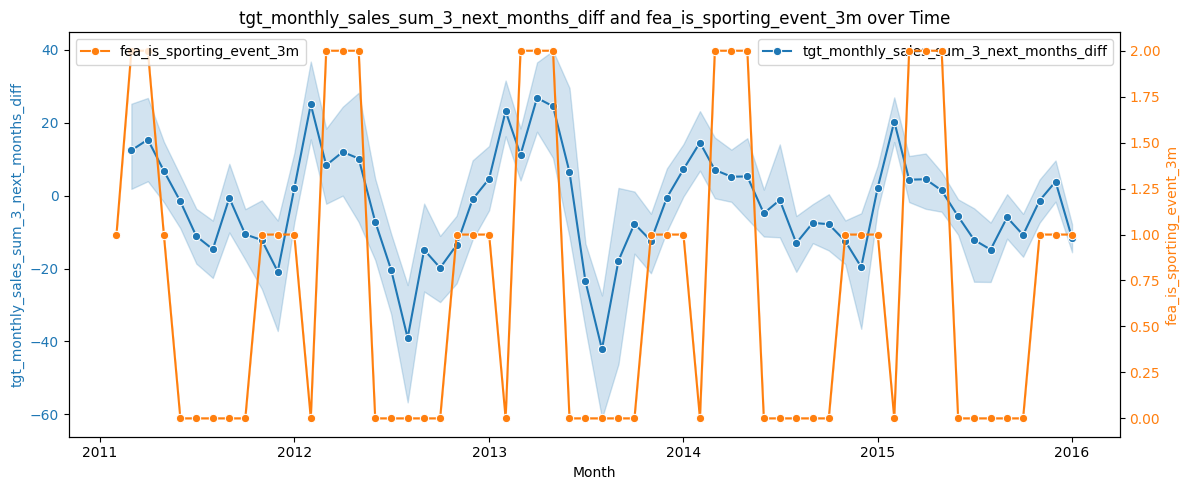

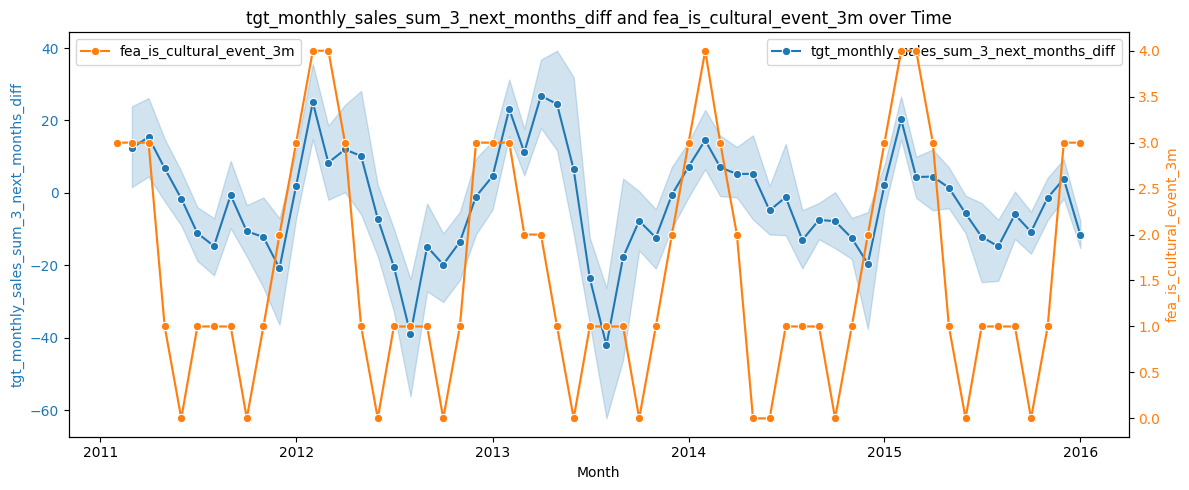

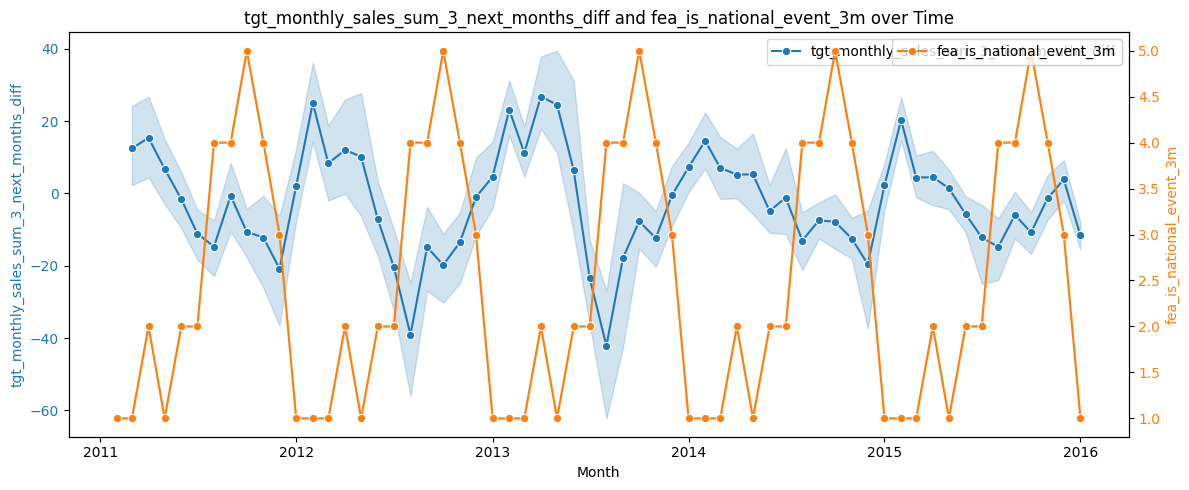

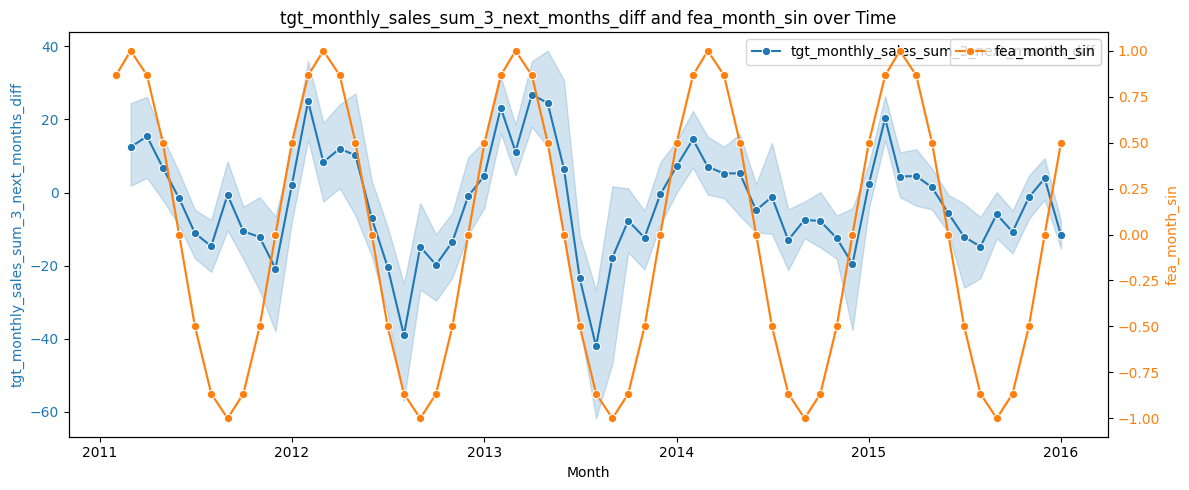

In [42]:
dept_id = "FOODS_3"
features_with_impact = list(df_significant[df_significant["department"]==dept_id]["feature"].unique())
for fea in features_with_impact:
    plot_tgt_impact_per_feature(dept_id, fea)

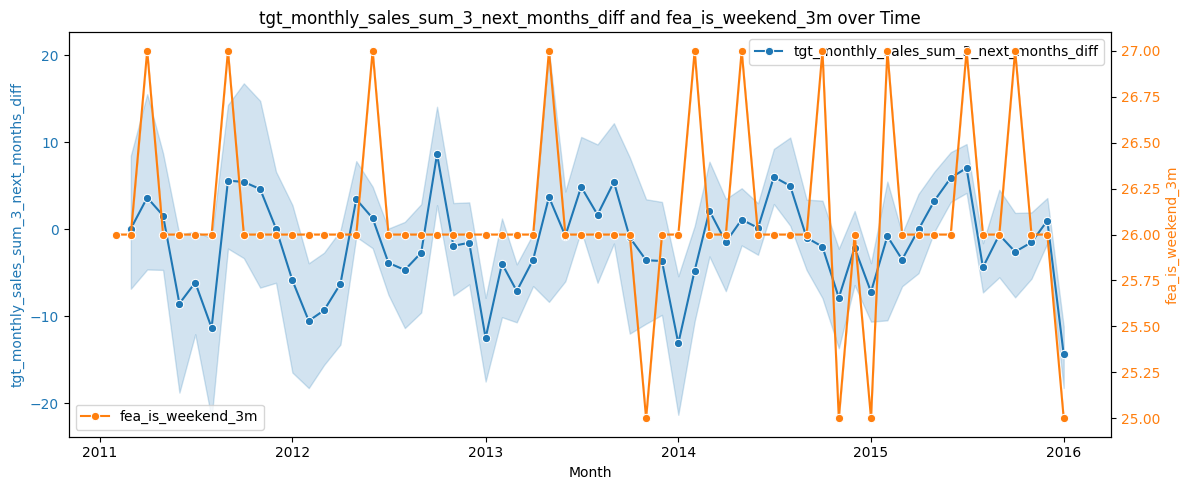

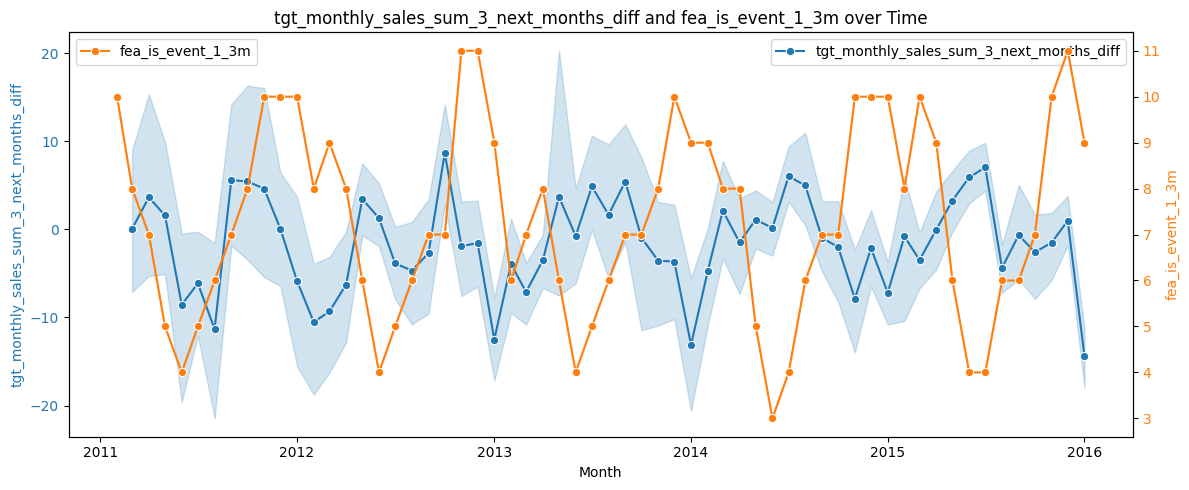

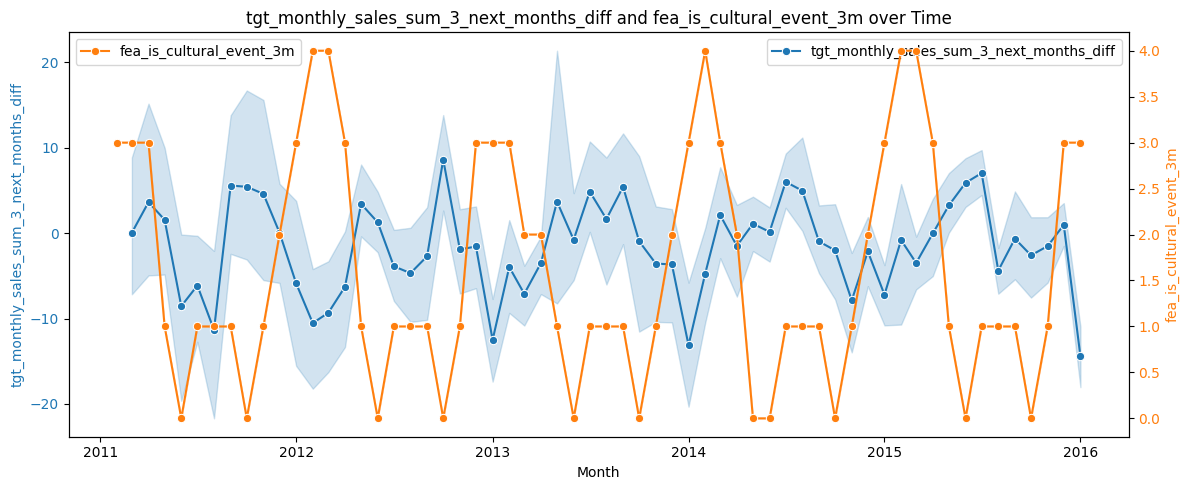

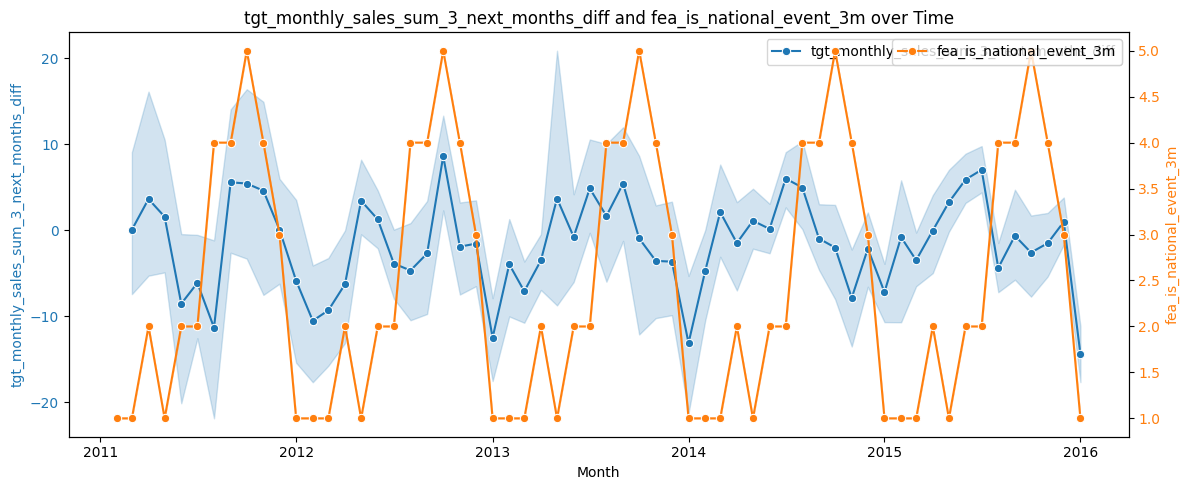

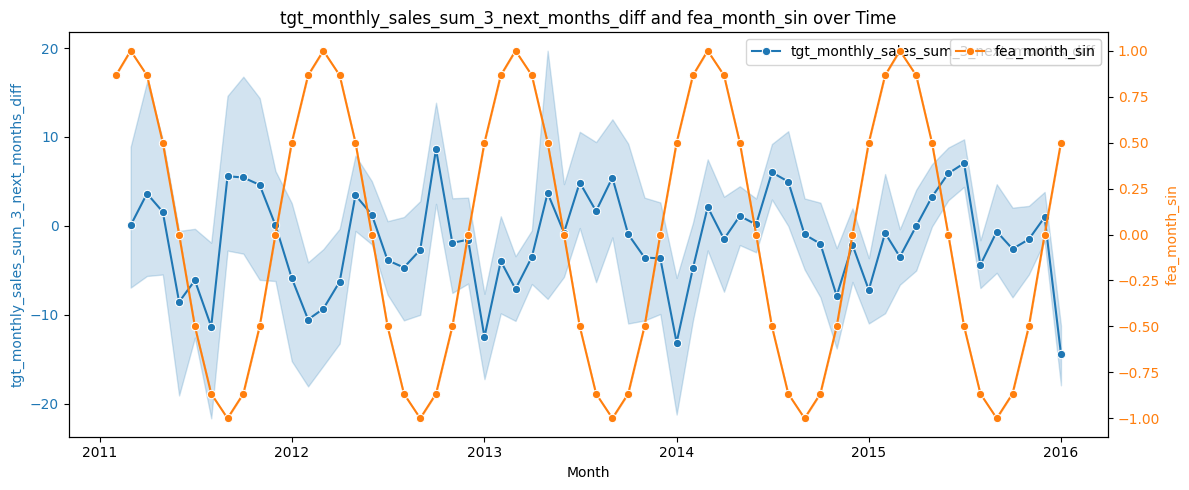

In [43]:
dept_id = "FOODS_2"
features_with_impact = list(df_significant[df_significant["department"]==dept_id]["feature"].unique())
for fea in features_with_impact:
    plot_tgt_impact_per_feature(dept_id, fea)

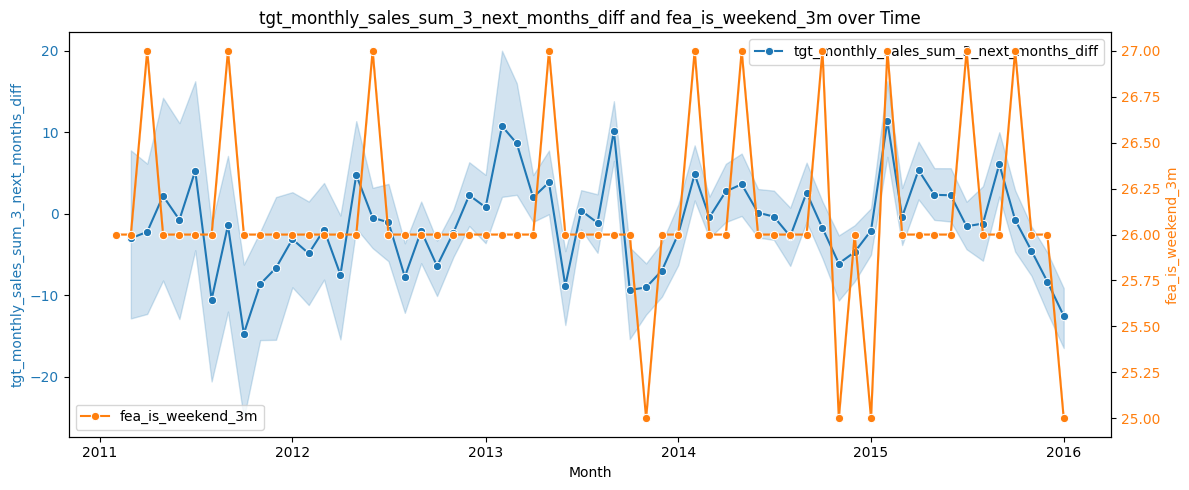

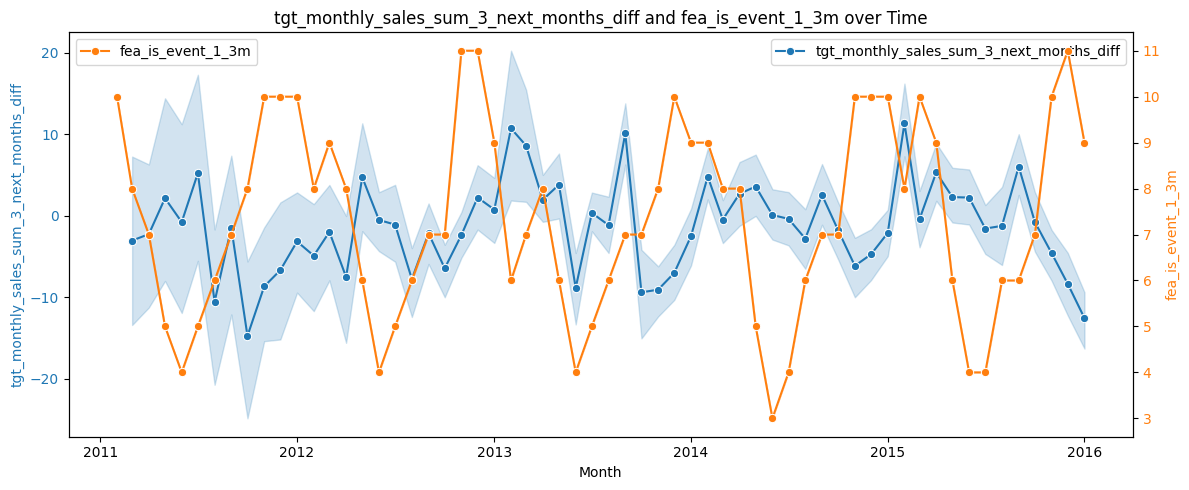

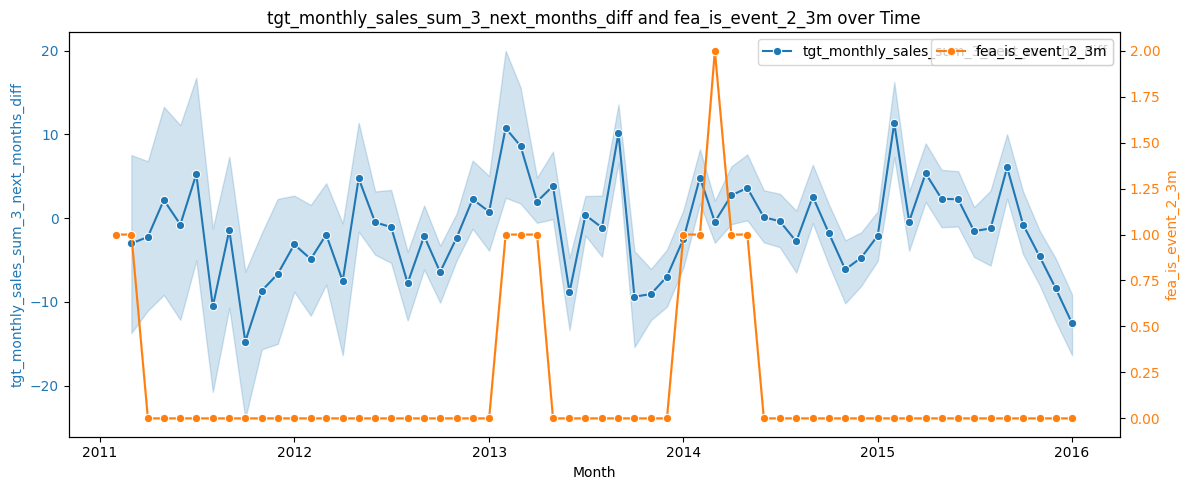

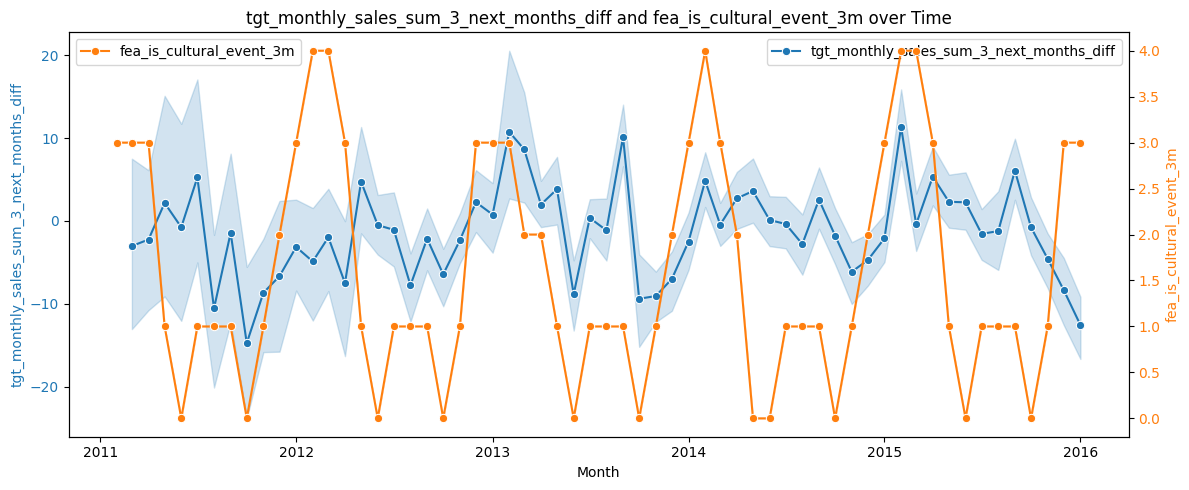

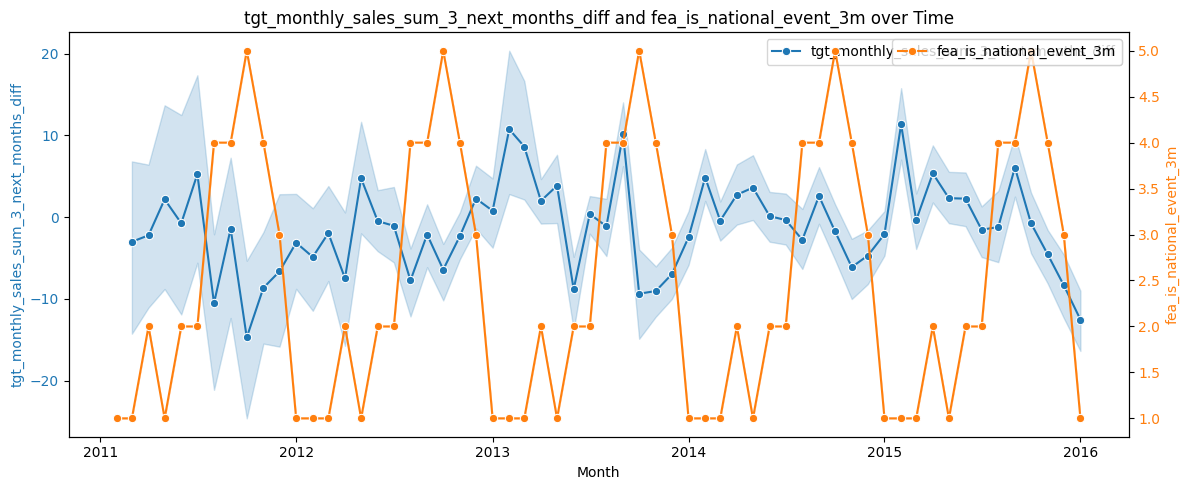

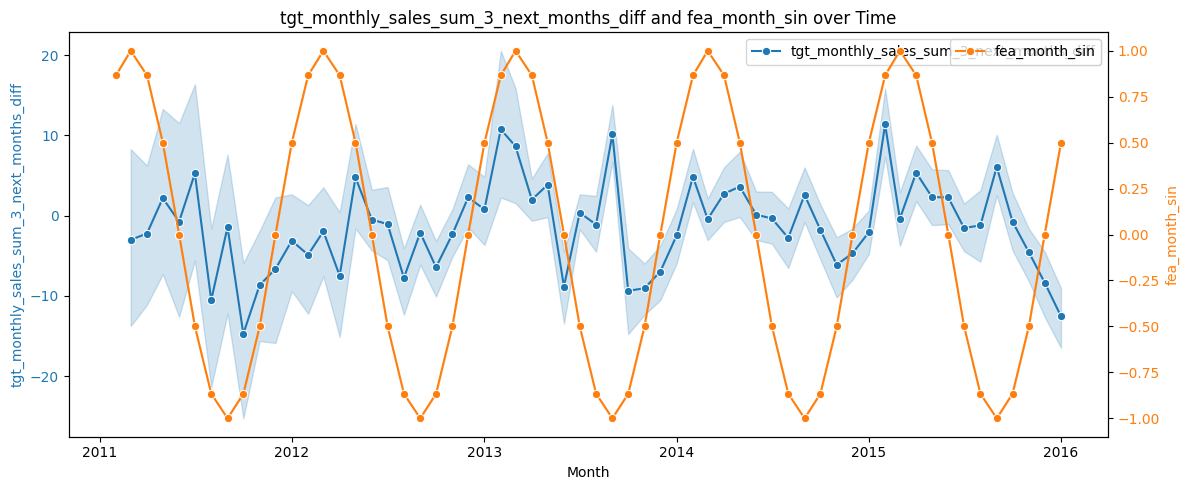

In [46]:
dept_id = "HOBBIES_1"
features_with_impact = list(df_significant[df_significant["department"]==dept_id]["feature"].unique())
for fea in features_with_impact:
    plot_tgt_impact_per_feature(dept_id, fea)

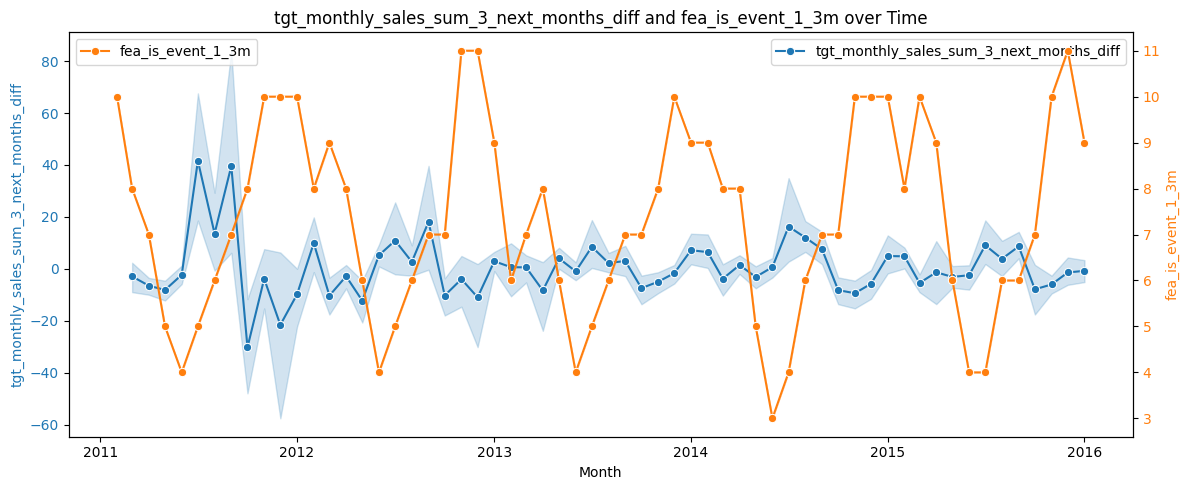

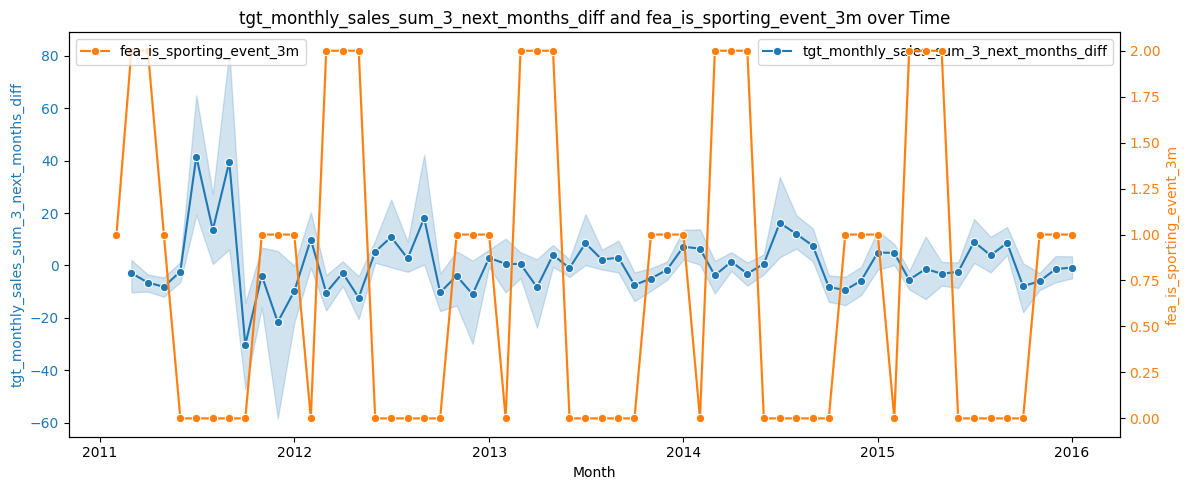

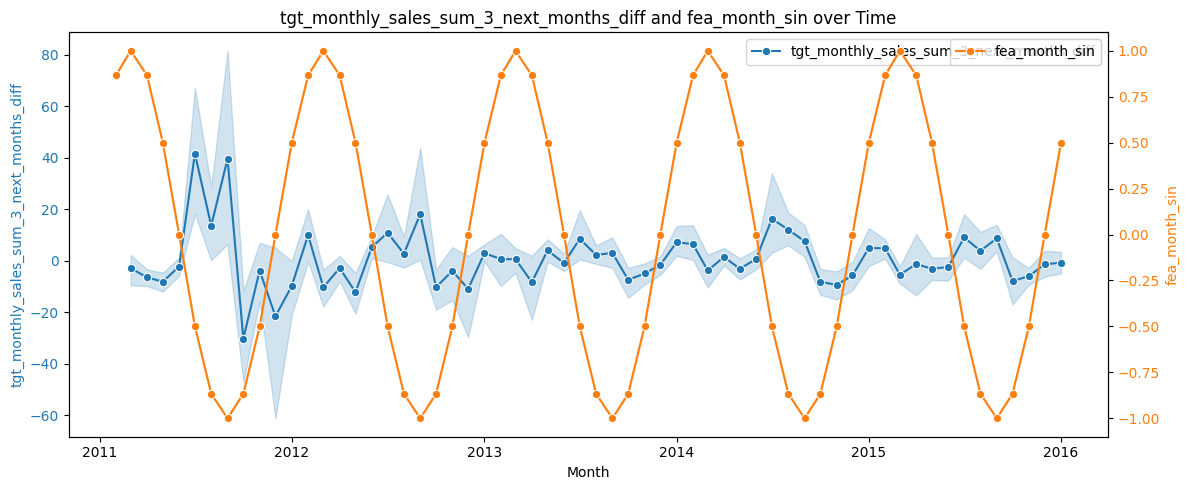

In [47]:
dept_id = "HOBBIES_2"
features_with_impact = list(df_significant[df_significant["department"]==dept_id]["feature"].unique())
for fea in features_with_impact:
    plot_tgt_impact_per_feature(dept_id, fea)

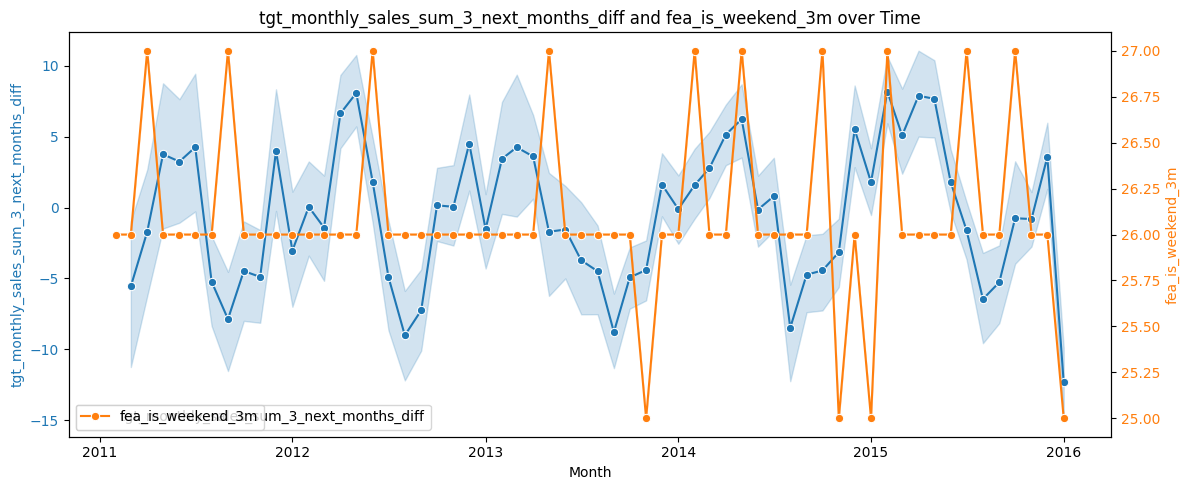

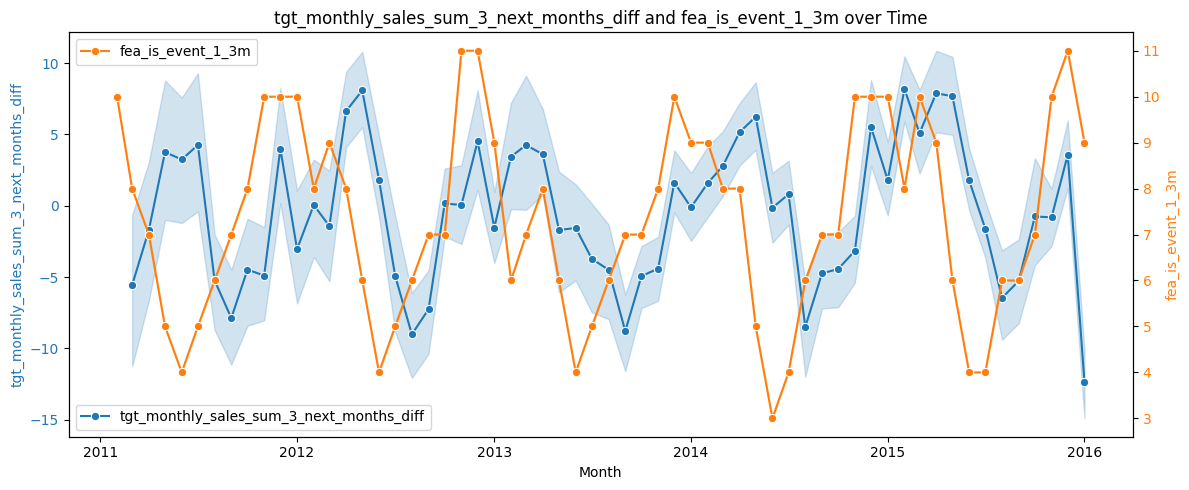

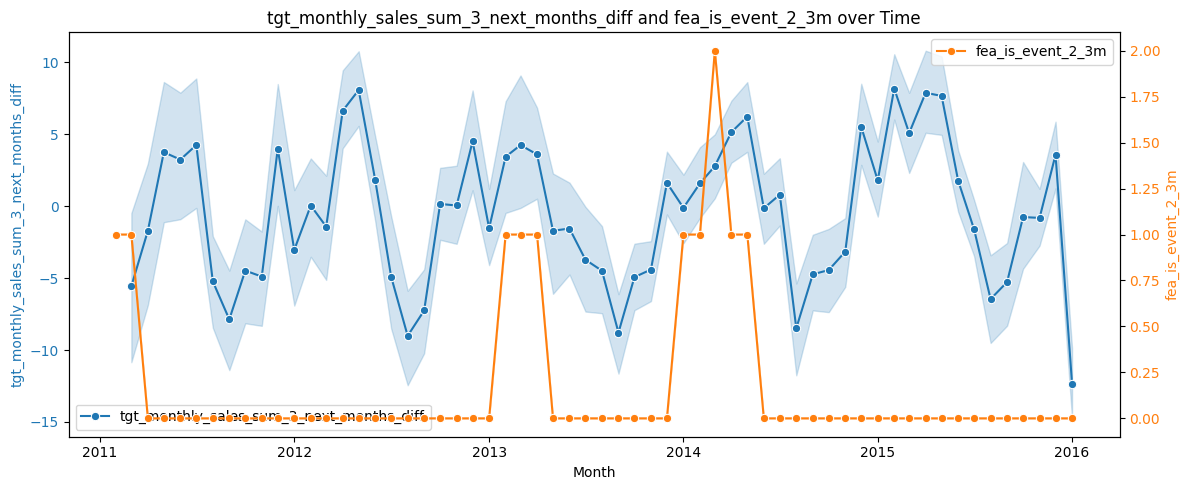

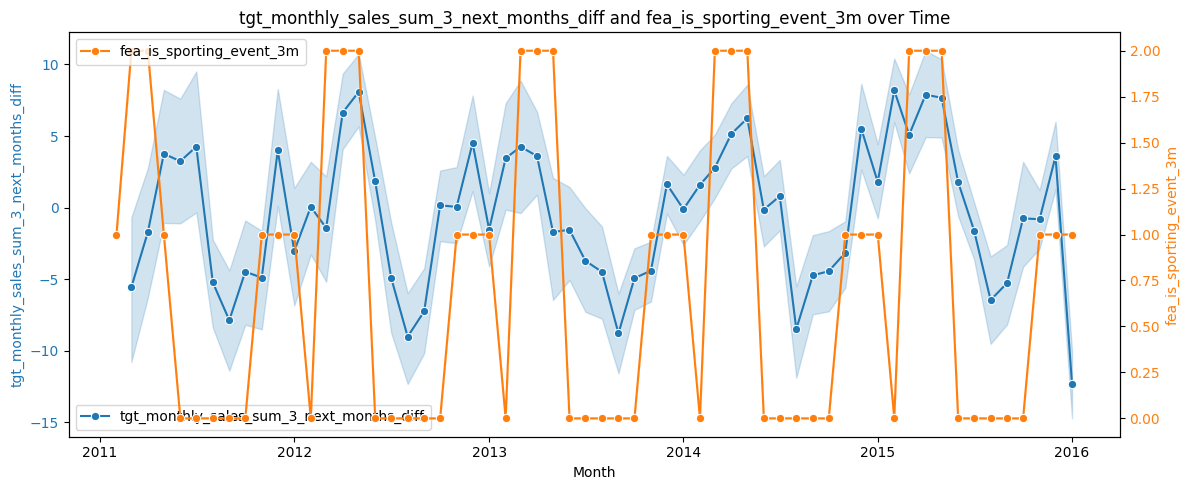

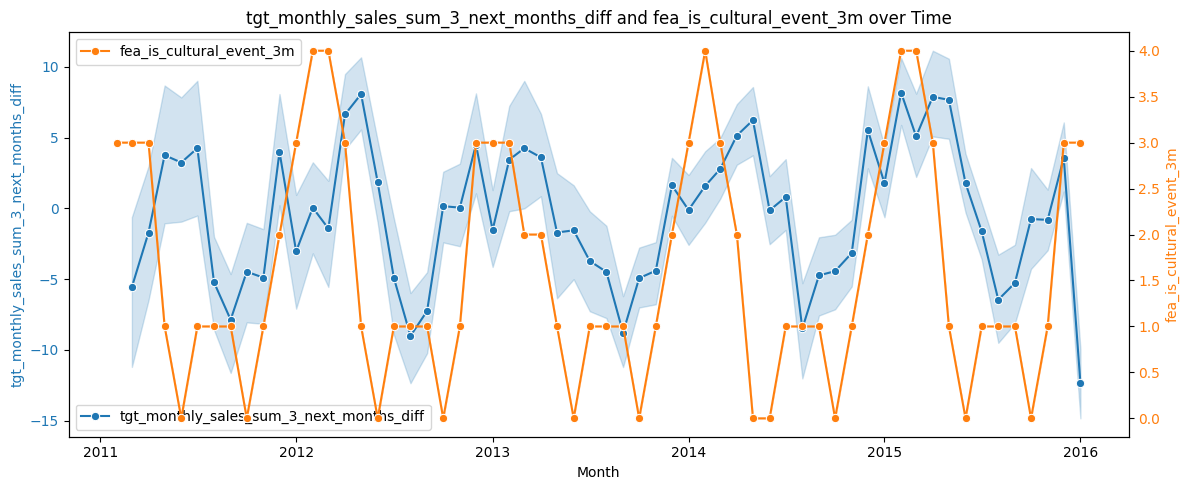

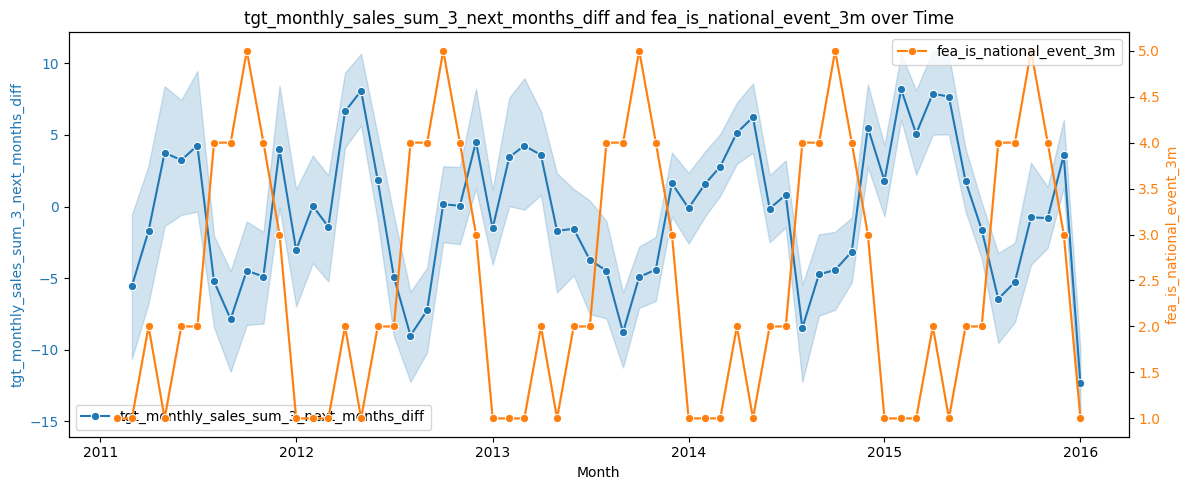

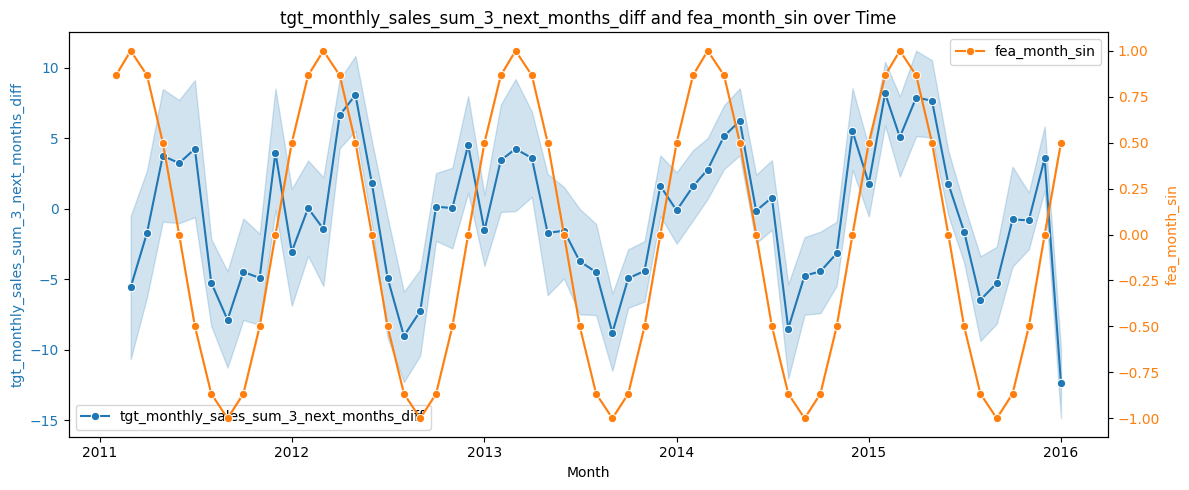

In [48]:
dept_id = "HOUSEHOLD_1"
features_with_impact = list(df_significant[df_significant["department"]==dept_id]["feature"].unique())
for fea in features_with_impact:
    plot_tgt_impact_per_feature(dept_id, fea)

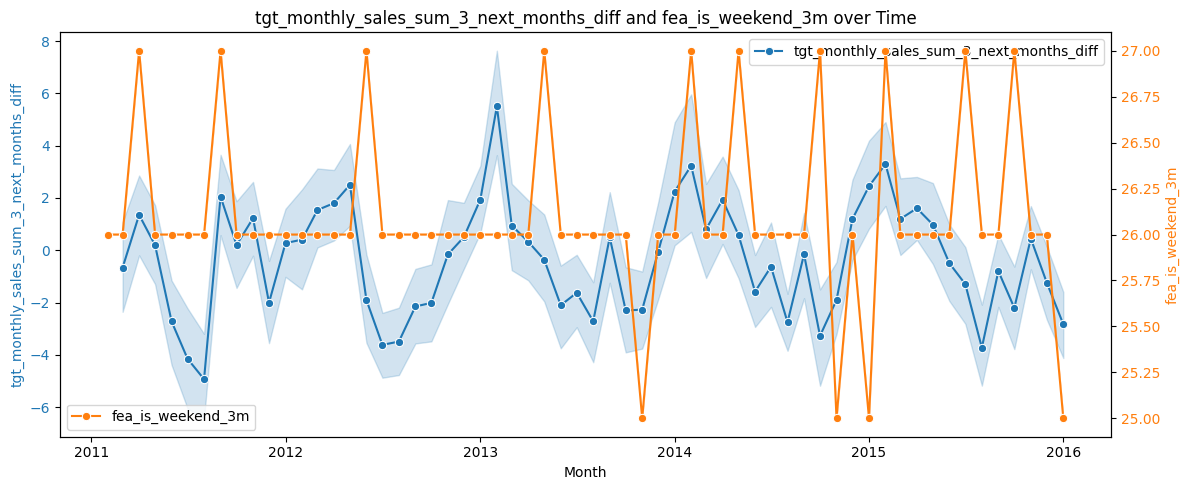

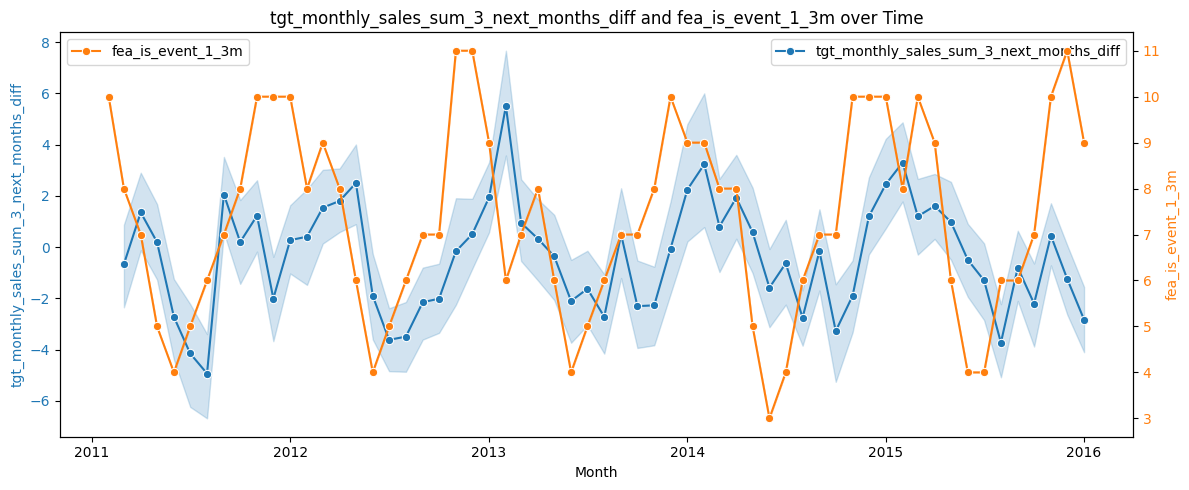

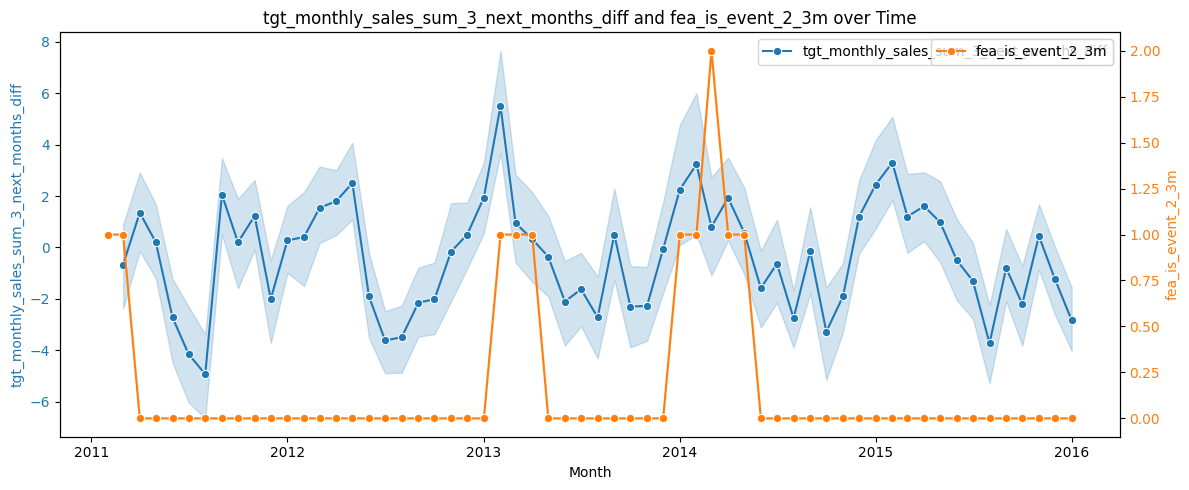

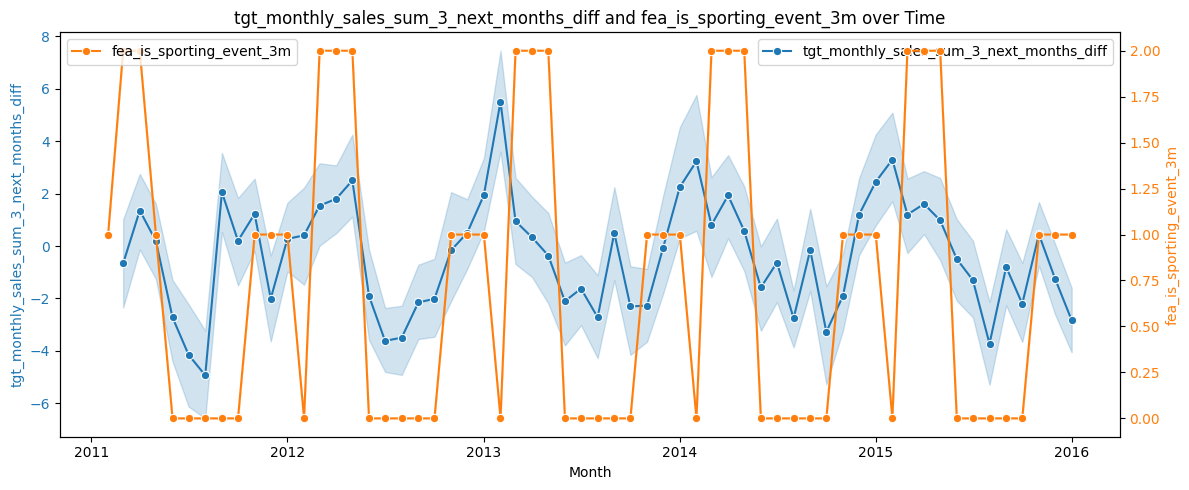

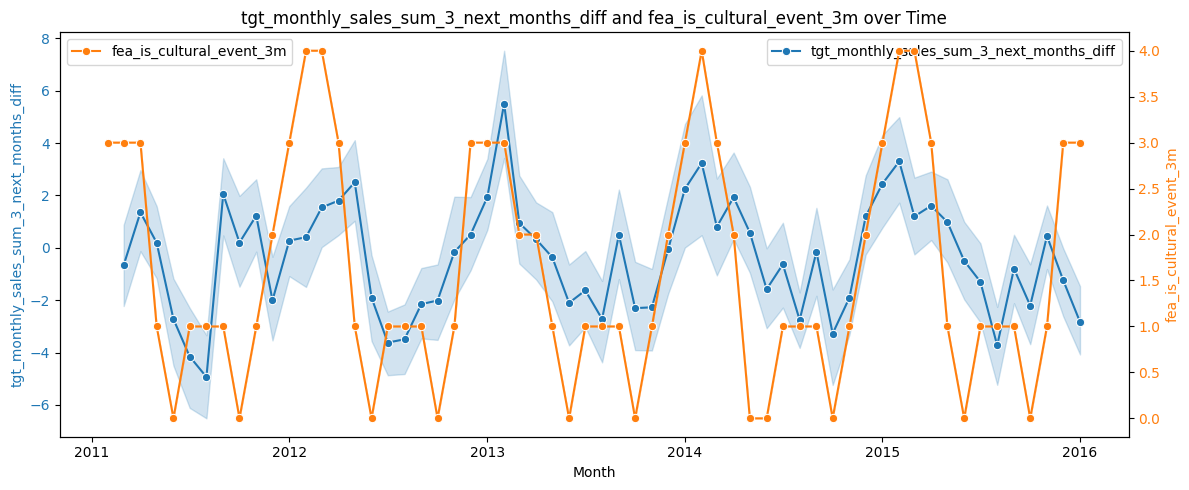

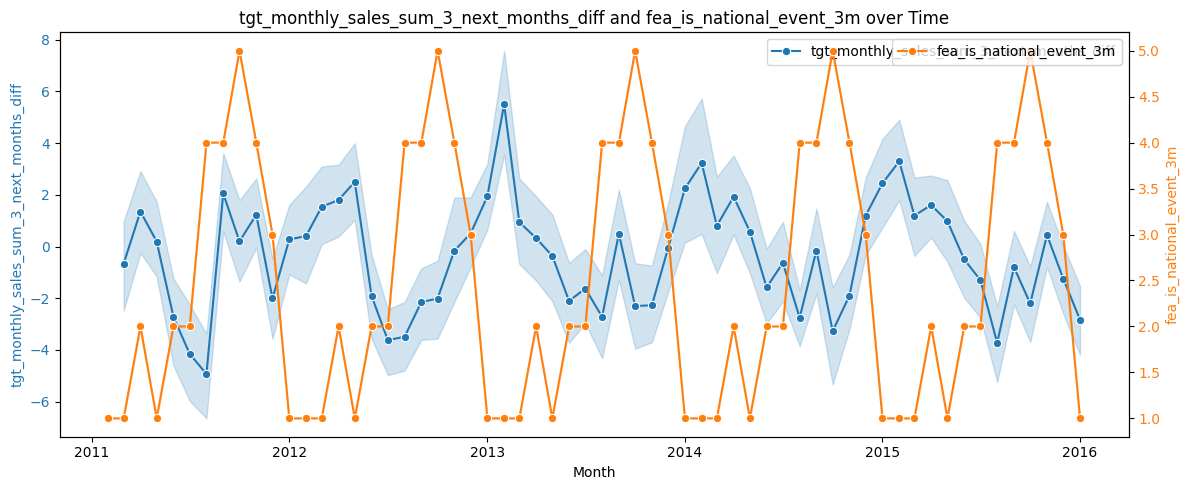

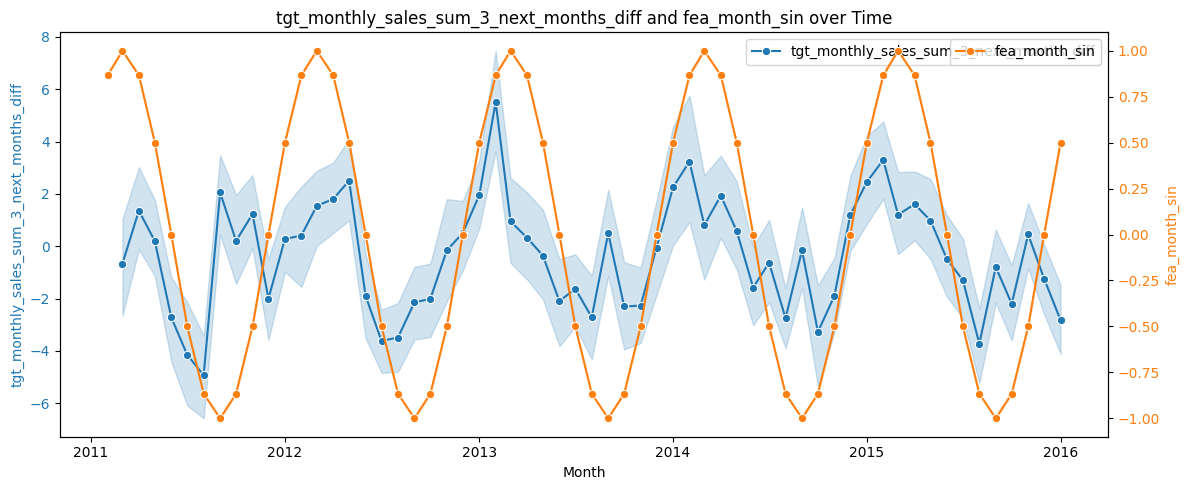

In [49]:
dept_id = "HOUSEHOLD_2"
features_with_impact = list(df_significant[df_significant["department"]==dept_id]["feature"].unique())
for fea in features_with_impact:
    plot_tgt_impact_per_feature(dept_id, fea)